# Denpasar Weather Forecasting with TensorFlow

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (12, 5)
mpl.rcParams['axes.grid'] = False

## The weather dataset

This data was collected from https://openweathermap.org, contains hourly weather data in Denpasar from January 1st, 1990 until January 7th, 2020. This data also has been uploaded to public data repository at https://www.kaggle.com/cornflake15/denpasarbalihistoricalweatherdata .
Originally, this dataset has 32 columns although we aren't using all of it in purpose of reducing complexity.

In [3]:
usecols = ['dt_iso', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 
           'clouds_all', 'weather_main', 'weather_description']
df = pd.read_csv('openweatherdata-denpasar-1990-2020v0.1.csv', parse_dates=True, index_col='dt_iso', usecols=usecols)
df.head()

temp  temp_min  temp_max  pressure  humidity  \
dt_iso                                                               
1990-01-01 00:00:00  25.82     25.82     25.82    1010.0        86   
1990-01-01 01:00:00  26.20     26.20     26.20    1011.0        84   
1990-01-01 02:00:00  26.45     26.45     26.45    1011.0        84   
1990-01-01 03:00:00  26.80     26.80     26.80    1011.0        82   
1990-01-01 04:00:00  27.04     27.04     27.04    1010.0        82   

                     wind_speed  wind_deg  clouds_all weather_main  \
dt_iso                                                               
1990-01-01 00:00:00        1.36       225          98         Rain   
1990-01-01 01:00:00        2.09       247          91         Rain   
1990-01-01 02:00:00        2.44       262          94         Rain   
1990-01-01 03:00:00        2.29       271          94         Rain   
1990-01-01 04:00:00        1.71       274          76       Clouds   

                    weather_description  
dt_iso                                   
1990-01-01 00:00:00          light rain  
1990-01-01 01:00:00          light rain  
1990-01-01 02:00:00          light rain  
1990-01-01 03:00:00          light rain  
1990-01-01 04:00:00       broken clouds

In [4]:
df.tail()

temp  temp_min  temp_max  pressure  humidity  wind_speed  \
dt_iso                                                                          
2020-01-07 19:00:00  27.0      27.0      27.0    1007.0        94         4.1   
2020-01-07 20:00:00  27.0      27.0      27.0    1007.0        94         5.7   
2020-01-07 21:00:00  28.0      28.0      28.0    1007.0        83         6.7   
2020-01-07 22:00:00  28.0      28.0      28.0    1007.0        83         6.2   
2020-01-07 23:00:00  28.0      28.0      28.0    1008.0        83         5.7   

                     wind_deg  clouds_all weather_main weather_description  
dt_iso                                                                      
2020-01-07 19:00:00       300          75       Clouds       broken clouds  
2020-01-07 20:00:00       300          75       Clouds       broken clouds  
2020-01-07 21:00:00       290          75       Clouds       broken clouds  
2020-01-07 22:00:00       290          40       Clouds    scattered clouds  
2020-01-07 23:00:00       300          40       Clouds    scattered clouds

**Total number of record and columns**

In [5]:
df.shape

(264924, 10)

**Data Split Function**

In [6]:
# Split the data by percentage
def num_data_train(percentage, data_length):
    num_data = percentage / 100 * data_length
    return int(num_data)

*Most of the code below is adapted from* **TimeSeries Forecasting with Tensorflow**

*Source: https://www.tensorflow.org/tutorials/structured_data/time_series*

## Forecast a univariate time series

In this part, we only test a basic forecasting method using a single feature which is temperature `(temp)`

**First we need to split the data with proportion of 70% data training**

In [7]:
TRAIN_SPLIT = num_data_train(70, df.shape[0]) # Split 70% of the data for training
tf.random.set_seed(13) # Setting seed to ensure reproducibility
print('Length of Data Train: {}'.format(TRAIN_SPLIT))

Length of Data Train: 185446


In [8]:
# Train a model using a single feature (temperature)
dt_temp = df['temp']
dt_temp.tail()

dt_iso
2020-01-07 19:00:00    27.0
2020-01-07 20:00:00    27.0
2020-01-07 21:00:00    28.0
2020-01-07 22:00:00    28.0
2020-01-07 23:00:00    28.0
Name: temp, dtype: float64

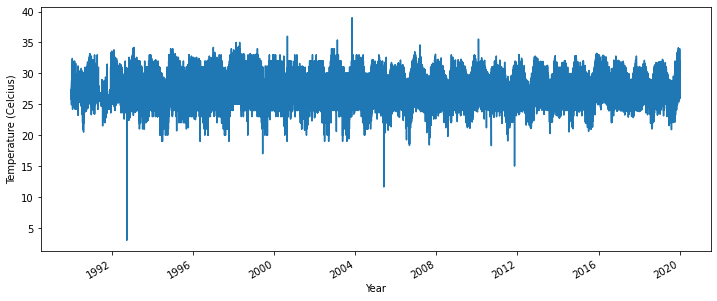

In [9]:
dt_temp.plot(subplots=True)
plt.xlabel('Year')
plt.ylabel('Temperature (Celcius)')
plt.show()

In [10]:
# Convert the dataframe into numpy array
array_temp = dt_temp.values
print(array_temp[:10]) # Print 10 elements for checking

[25.82 26.2  26.45 26.8  27.04 27.23 27.32 27.29 27.34 27.23]


In [11]:
# Scaling the features
array_temp_mean = array_temp[:TRAIN_SPLIT].mean()
array_temp_std = array_temp[:TRAIN_SPLIT].std()
print('Training Data Mean: {}'.format(array_temp_mean))
print('\nTraining Data Std.Dev: {}'.format(array_temp_std))

Training Data Mean: 27.1836268239811

Training Data Std.Dev: 1.9980058874922433


In [12]:
# Standardize the data
array_temp = (array_temp - array_temp_mean) / array_temp_std
print(array_temp)

[-0.6824939  -0.49230427 -0.36717951 ...  0.40859398  0.40859398
  0.40859398]


In [13]:
# create a function that return the time windows for the model to train on
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
        
    return np.array(data), np.array(labels)

In this part, the model will be given the last **`n`** recorded temperature observation, and needs to learn to predict the temperature at the next **`m`** time step.

In [14]:
# Create the univariate model
data_past_history = 30 # number of last recorded data (n)
data_future_target = 0 # number of time step (m)

x_train, y_train = univariate_data(array_temp, 0, TRAIN_SPLIT, data_past_history, data_future_target)
x_val, y_val = univariate_data(array_temp, TRAIN_SPLIT, None, data_past_history, data_future_target)

print('Single window of past history:')
print(x_train[0])
print('\n Target temperature to predict:')
print(y_train[0])

Single window of past history:
[[-0.6824939 ]
 [-0.49230427]
 [-0.36717951]
 [-0.19200485]
 [-0.07188509]
 [ 0.02320973]
 [ 0.06825464]
 [ 0.05323967]
 [ 0.07826462]
 [ 0.02320973]
 [ 0.10829456]
 [ 0.07325963]
 [-0.19700984]
 [-0.44725935]
 [-0.56237413]
 [-0.63244399]
 [-0.63744898]
 [-0.65246396]
 [-0.69750887]
 [-0.8326436 ]
 [-1.01782824]
 [-1.0428532 ]
 [-1.03284321]
 [-1.07788813]
 [-1.01782824]
 [-0.99280329]
 [-0.96777834]
 [-0.8326436 ]
 [-0.85766856]
 [-0.75256376]]

 Target temperature to predict:
-0.8076186532194914


In [15]:
def create_time_steps(length):
    return list(range(-length, 0))

In [16]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0
        
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
       
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

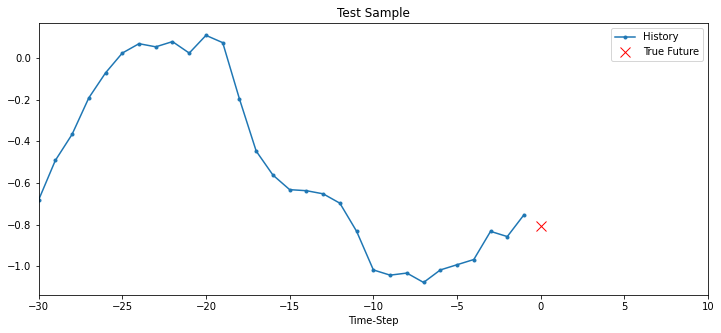

In [17]:
show_plot([x_train[0], y_train[0]], 0, 'Test Sample')
plt.show()

### Modeling the data training with Machine Learning

In this part,  we compared two ML methods in Tensorflow. First is the regular `Sequential` method and second is `LSTM` method.

In [18]:
from tensorflow.keras import layers
tf.keras.backend.clear_session()  # For easy reset of notebook state.

# Normal Sequential model
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, input_shape=x_train.shape[-2:]), 
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compare with simple LSTM Model, according to several sources LSTM is suitable for modeling time series data
model_2 = tf.keras.models.Sequential(
    [tf.keras.layers.LSTM(8, input_shape=x_train.shape[-2:]), tf.keras.layers.Dense(1)]
)
model_1.summary()
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30, 16)            32        
_________________________________________________________________
dense_1 (Dense)              (None, 30, 16)            272       
_________________________________________________________________
dense_2 (Dense)              (None, 30, 1)             17        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 320       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 

In [19]:
model_1.compile(optimizer='adam', loss='mae')
model_2.compile(optimizer='adam', loss='mae')

**Further reading:**
    
    1. https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network
    2. https://stackoverflow.com/questions/45943675/meaning-of-validation-steps-in-keras-sequential-fit-generator-parameter-list/45944225
    3. https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

In [20]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

datatrain = tf.data.Dataset.from_tensor_slices((x_train, y_train))
datatrain = datatrain.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

dataval = tf.data.Dataset.from_tensor_slices((x_val, y_val))
dataval = dataval.batch(BATCH_SIZE).repeat()

In [21]:
EPOCHS = 10 # Test using only 10 epoch
STEPS_PER_EPOCH = 200 # number of time steps
VALIDATION_STEPS = 50

# Train the model
model_1_history = model_1.fit(datatrain, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_data=dataval, 
                      validation_steps=VALIDATION_STEPS)
model_2_history = model_2.fit(datatrain, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_data=dataval, 
                      validation_steps=VALIDATION_STEPS)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 2s 8ms/step - loss: 0.6002 - val_loss: 0.7154
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 0.8129 - val_loss: 0.7022
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 0.7974 - val_loss: 0.7008
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.6201 - val_loss: 0.7518
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 0.7549 - val_loss: 0.7077
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 0.7994 - val_loss: 0.7036
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 0.7809 - val_loss: 0.7024
Epoch 8/10
200/200 [==============================] - 1s 4ms/step - loss: 0.5791 - val_loss: 0.7198
Epoch 9/10
200/200 [==============================] - 1s 4ms/step - loss: 0.8123 - val_loss: 0.7033
Epoch 10/10
200/200 [==============================] - 1s

In [22]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    plt.figure()
    
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title(title)
    plt.legend()
    
    plt.show()

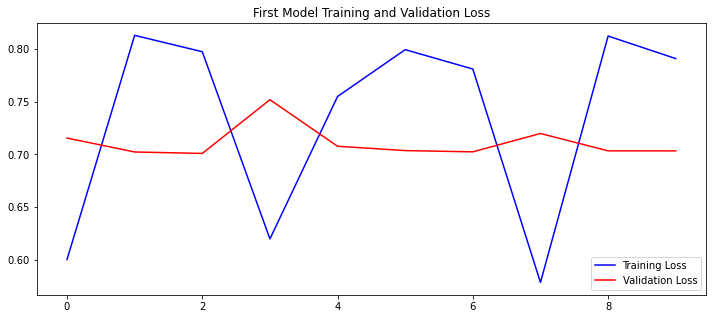

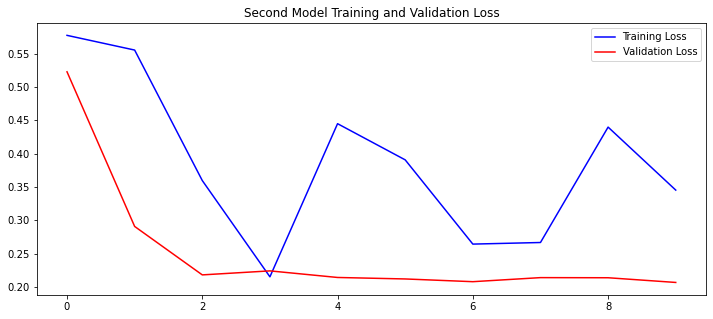

In [23]:
plot_train_history(model_1_history, 'First Model Training and Validation Loss')
plot_train_history(model_2_history, 'Second Model Training and Validation Loss')

**The graph above indicates that the model performance was not really good because we only use single feature (temperature)**

The first model is not really clear whether it is overfit or underfit, but the second model clealy underfit. Second model need hyperparameter tuning or because it used only single feature.

In the next section we will use multi-feature/multivariate forecasting.

Further readings:
    1. https://developers.google.com/machine-learning/crash-course/descending-into-ml/training-and-loss
    2. https://stackoverflow.com/questions/48226086/training-loss-and-validation-loss-in-deep-learning

# Multivariate Forecasting

We used five features which are average temperature (`temp`), minimum temperature (`temp_min`), maximum temperature (`temp_max`), air pressure (`pressure`), and air humidity (`humidity`)

In [24]:
df_multivariate = df[['temp', 'temp_min', 'temp_max', 'pressure', 'humidity']]
df_multivariate.head()

temp  temp_min  temp_max  pressure  humidity
dt_iso                                                            
1990-01-01 00:00:00  25.82     25.82     25.82    1010.0        86
1990-01-01 01:00:00  26.20     26.20     26.20    1011.0        84
1990-01-01 02:00:00  26.45     26.45     26.45    1011.0        84
1990-01-01 03:00:00  26.80     26.80     26.80    1011.0        82
1990-01-01 04:00:00  27.04     27.04     27.04    1010.0        82

We analyze the relation among the features with correlation matrix

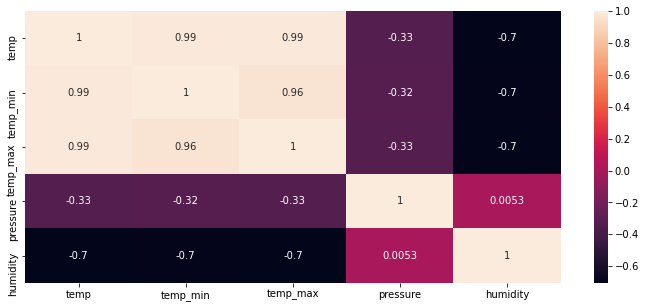

In [25]:
import seaborn as sns

sns.heatmap(df_multivariate.corr(), annot=True)
plt.show()

**Because data in 2020 is only contain seven days (January 1st - January 7th), we decided to use data from 1990 until 2019.**

In [26]:
# Don't use data in 2020
df_multivariate = df_multivariate.loc['1990':'2019']
df_multivariate.tail()

temp  temp_min  temp_max  pressure  humidity
dt_iso                                                            
2019-12-31 19:00:00  27.08      27.0      27.2    1009.0        88
2019-12-31 20:00:00  26.64      26.0      27.0    1009.0        94
2019-12-31 21:00:00  26.00      26.0      26.0    1009.0        94
2019-12-31 22:00:00  26.00      26.0      26.0    1009.0        94
2019-12-31 23:00:00  27.00      27.0      27.0    1010.0        88

In [27]:
# Convert the dataframe to numpy array
dt_multivariate = df_multivariate.values
print('Number of dataset: {}'.format(len(df_multivariate)))
print('Print 10 samples of data: \n{}'.format(dt_multivariate[:10]))

Number of dataset: 264756
Print 10 samples of data: 
[[  25.82   25.82   25.82 1010.     86.  ]
 [  26.2    26.2    26.2  1011.     84.  ]
 [  26.45   26.45   26.45 1011.     84.  ]
 [  26.8    26.8    26.8  1011.     82.  ]
 [  27.04   27.04   27.04 1010.     82.  ]
 [  27.23   27.23   27.23 1009.     82.  ]
 [  27.32   27.32   27.32 1008.     82.  ]
 [  27.29   27.29   27.29 1008.     82.  ]
 [  27.34   27.34   27.34 1007.     81.  ]
 [  27.23   27.23   27.23 1007.     82.  ]]


Normalizing the data using StandardScaler from sklearn, instead of using the conventional calculation like the above before

In [28]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
dt_multivariate = sc.fit_transform(dt_multivariate)
print('Normalized data:')
print(dt_multivariate[10])
print(dt_multivariate.shape)

Normalized data:
[ 0.06489342  0.1281178   0.00158411 -0.88977112  0.01811545]
(264756, 5)


## Single Step Model

First, we use single step model to analyze how the ML methods performs.

In [228]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
            
    return np.array(data), np.array(labels)

We change the proportion of data training to 60%

In [229]:
TRAIN_SPLIT = num_data_train(60, df.shape[0]) # Split

Use number of hours (**`past_history`**) of data to predict future (**`future_target`**) hourly temperature

Further reading:
1. https://databricks.com/blog/2019/09/10/doing-multivariate-time-series-forecasting-with-recurrent-neural-networks.html

In [230]:
past_history = 24 * 7 # number of hours history data
future_target = 24 * 3 # number of hours future target
STEP = 24 # The time step is dayly (24 hours)

x_train_single, y_train_single = multivariate_data(dt_multivariate, dt_multivariate[:, 1], 0, TRAIN_SPLIT, past_history, 
                                                   future_target, STEP, single_step=True)
x_val_single, y_val_single = multivariate_data(dt_multivariate, dt_multivariate[:, 1], TRAIN_SPLIT, None, past_history, 
                                               future_target, STEP, single_step=True)

Note:
    - LSTMs expect 3D input
    - LSTMs donâ€™t like sequences of more than 200-400 time steps, so the data will need to be split into samples.

In [231]:
print(len(x_train_single), len(y_train_single))
print(len(x_val_single), len(y_val_single))

158786 158786
105562 105562


In [232]:
# Test at a single data point
print('Single window of past history: {}'.format(x_train_single[0].shape))

Single window of past history: (7, 5)


In [233]:
BATCH_SIZE = 806 # 256
BUFFER_SIZE = 10000

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

`steps_per_epoch * batch_size = number_of_rows_in_train_data`

For example, if you have 100 training samples, then num_samples = 100, or the number of rows of x_train is 100.

In [234]:
print(x_train_single.shape, x_val_single.shape)
print()
print(y_train_single.shape, y_val_single.shape)

(158786, 7, 5) (105562, 7, 5)

(158786,) (105562,)


In [235]:
# 2 layers LSTM
tf.keras.backend.clear_session()
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(32, activation='relu'))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer='sgd', loss='mae') # Use the Stochastic Gradient Descent optimizer

single_step_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4864      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 5,953
Trainable params: 5,953
Non-trainable params: 0
_________________________________________________________________


In [236]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(806, 1)


In [237]:
EPOCHS = 10 # 10
STEPS_PER_EPOCH = 180 # 200
VALIDATION_STEPS = 24 # 50
single_step_model_history = single_step_model.fit(train_data_single, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH,
                                            validation_data=val_data_single, validation_steps=VALIDATION_STEPS)

Train for 180 steps, validate for 24 steps
Epoch 1/10
180/180 [==============================] - 9s 49ms/step - loss: 0.6302 - val_loss: 0.5413TA: 0s - los
Epoch 2/10
180/180 [==============================] - 7s 38ms/step - loss: 0.5441 - val_loss: 0.5430
Epoch 3/10
180/180 [==============================] - 7s 38ms/step - loss: 0.5335 - val_loss: 0.5430
Epoch 4/10
180/180 [==============================] - 7s 38ms/step - loss: 0.5299 - val_loss: 0.5430
Epoch 5/10
180/180 [==============================] - 7s 37ms/step - loss: 0.5295 - val_loss: 0.5444
Epoch 6/10
180/180 [==============================] - 7s 38ms/step - loss: 0.5272 - val_loss: 0.5419
Epoch 7/10
180/180 [==============================] - 7s 38ms/step - loss: 0.5216 - val_loss: 0.5319
Epoch 8/10
180/180 [==============================] - 7s 38ms/step - loss: 0.5209 - val_loss: 0.5279
Epoch 9/10
180/180 [==============================] - 7s 38ms/step - loss: 0.5251 - val_loss: 0.5279
Epoch 10/10
180/180 [===============

In [238]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
          plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
          plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

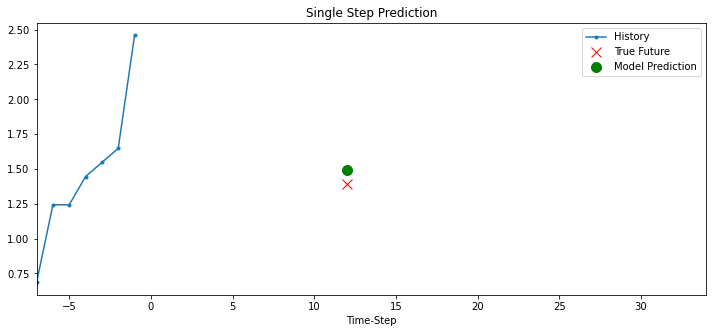

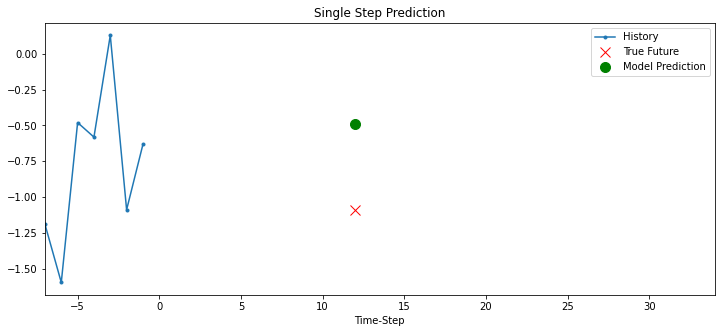

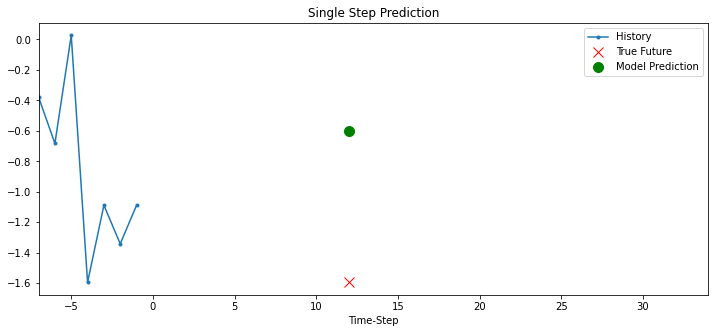

In [239]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

In [240]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    plt.figure()
    
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.title(title)
    plt.legend()
    plt.show()

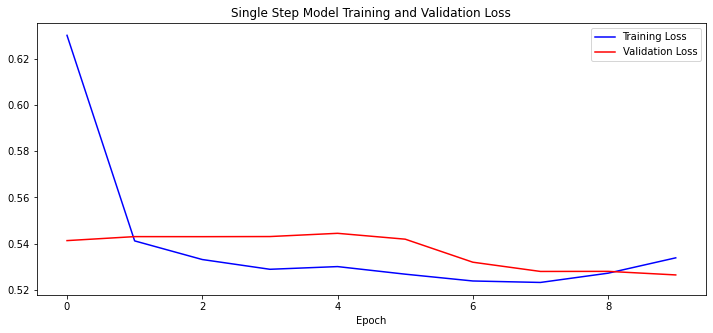

In [241]:
plot_train_history(single_step_model_history, 'Single Step Model Training and Validation Loss')

## Multi Step Model

In a single step setup, the model learns to predict a single point in the future based on history provided

In [242]:
past_history = 24 * 7
future_target = 24 * 3
STEP = 24 # We can customize how many time steps that we want to use

x_train_multi, y_train_multi = multivariate_data(dt_multivariate, dt_multivariate[:, 1], 0, TRAIN_SPLIT, past_history, 
                                                   future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dt_multivariate, dt_multivariate[:, 1], TRAIN_SPLIT, None, past_history, 
                                               future_target, STEP)

In [243]:
print(len(x_train_multi), len(y_train_multi))
print(len(x_val_multi), len(y_val_multi))

158786 158786
105562 105562


In [244]:
print(x_train_single.shape, x_val_single.shape)
print()
print(y_train_single.shape, y_val_single.shape)

(158786, 7, 5) (105562, 7, 5)

(158786,) (105562,)


In [245]:
# Test at a single data point
print('Single window of past history: {}'.format(x_train_multi[0].shape))
print('\n Target temperature to predict: {}'.format(y_train_multi[0].shape))

Single window of past history: (7, 5)

 Target temperature to predict: (72,)


In [246]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [247]:
def multi_step_plot(history, true_future, prediction):
#     plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    
    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo', label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro', label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

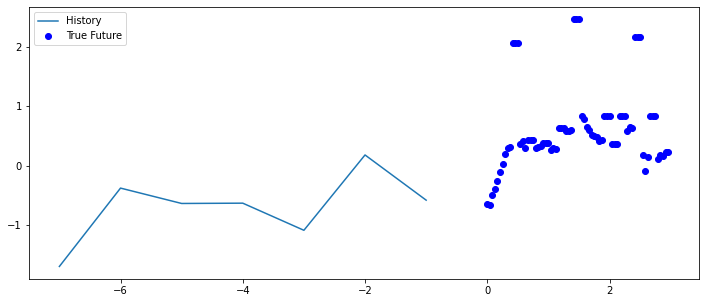

In [248]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

In [249]:
tf.keras.backend.clear_session()

# 5 layer LSTM
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
multi_step_model.add(tf.keras.layers.Dense(32, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(32, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(32, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(future_target)) # the number output layer should be the same as future target
multi_step_model.compile(optimizer='sgd', loss='mae')

multi_step_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4864      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 72)                2376      
Total params: 10,408
Trainable params: 10,408
Non-trainable params: 0
_________________________________________________________________


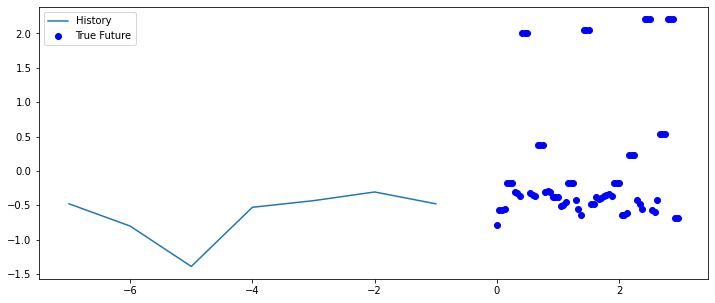

In [250]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [251]:
EPOCHS = 50 # 10
STEPS_PER_EPOCH = 180 # 200
VALIDATION_STEPS = 250 # 50

multi_step_model_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=STEPS_PER_EPOCH,
                                          validation_data=val_data_multi,
                                          validation_steps=VALIDATION_STEPS)

Train for 180 steps, validate for 250 steps
Epoch 1/50
180/180 [==============================] - 12s 68ms/step - loss: 0.8021 - val_loss: 0.7848
Epoch 2/50
180/180 [==============================] - 12s 68ms/step - loss: 0.8001 - val_loss: 0.7839
Epoch 3/50
180/180 [==============================] - 11s 62ms/step - loss: 0.7963 - val_loss: 0.7830
Epoch 4/50
180/180 [==============================] - 11s 61ms/step - loss: 0.7953 - val_loss: 0.7822
Epoch 5/50
180/180 [==============================] - 11s 61ms/step - loss: 0.8003 - val_loss: 0.7814
Epoch 6/50
180/180 [==============================] - 11s 61ms/step - loss: 0.7928 - val_loss: 0.7807
Epoch 7/50
180/180 [==============================] - 11s 61ms/step - loss: 0.7850 - val_loss: 0.7801
Epoch 8/50
180/180 [==============================] - 11s 61ms/step - loss: 0.7941 - val_loss: 0.7795
Epoch 9/50
180/180 [==============================] - 11s 62ms/step - loss: 0.7941 - val_loss: 0.7789
Epoch 10/50
180/180 [=================

In [252]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    plt.figure()
    
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.title(title)
    plt.legend()
    plt.show()

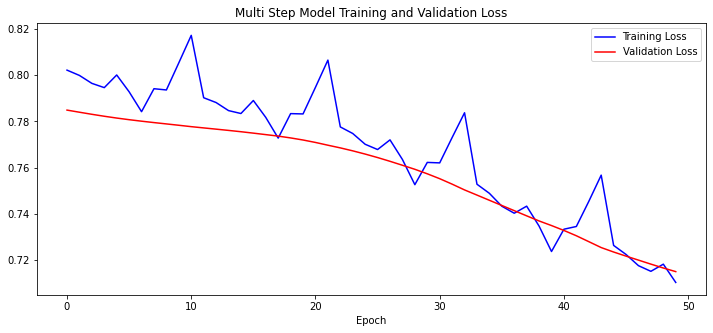

In [253]:
plot_train_history(multi_step_model_history, 'Multi Step Model Training and Validation Loss')

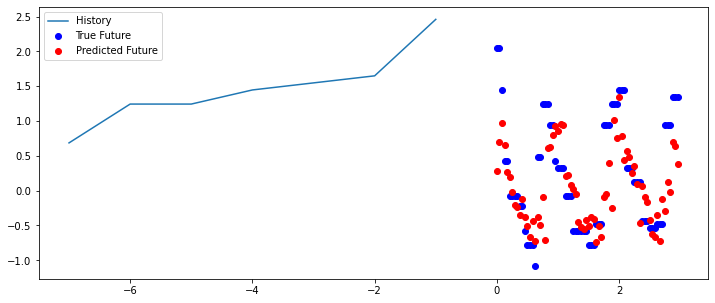

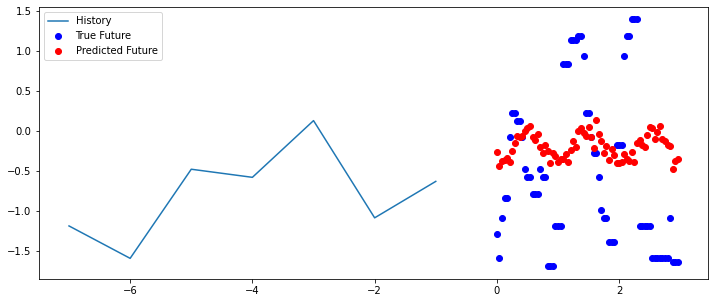

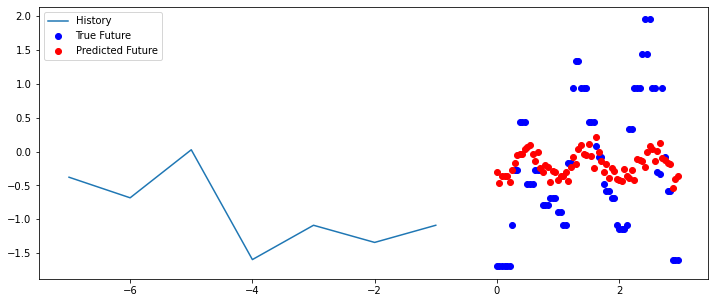

In [254]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])